# Modelling patch-clamp experiments: electronic compensation

In the [last notebook](./artefacts-1-modelling-patch-clamp.ipynb), we introduced an electrical schematic that can serve as a model of the patch-clamp set up, with distortions by leak, offsets, and unwanted capacitances.
To compensate for these unwanted effects, patch-clamp amplifiers contain special circuitry.
In this notebook we extend our model to include the effects of these compensations, as modelled in [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0348).

We will deal mostly with _transient_ distortions of the recorded output signal, which we call _artefacts_, and with transient differences between the true and intended membrane potential, which are an example of _imperfect control_.
These terms, and general strategies for dealing with their effects, are discussed in [Appendix H](./appendix-H-strategies.ipynb).
Stochastic and periodic noise are not discussed here, but a brief discussion is given in [Appendix I](./appendix-I-inspecting-noise.ipynb).

## Zeroing and the liquid junction potential ($E_\text{off}$)

In the last notebook we introduced $E_\text{off}$, which represents the sum of various voltage offsets that are incurred in the experimental setup.
This offset is usually corrected by a dial or a digital control that allows the experimenter to subtract an equal offset $-E_\text{off}^*$.
To allow for the idea that this correction is imperfect, either because it was set imperfectly or because $E_\text{off}$ drifted over time, we now introduce a symbol for the error in the offset correction $E_\text{off}^\dagger$ as
\begin{equation}
E_\text{off}^\dagger = E_\text{off} - E_\text{off}^*
\end{equation}

In the schematic, we will simply replace $E_\text{off}$ with the remaining error.

<img src="resources/patch-comp-1-Eoff.png" style="margin:auto" />

_**Figure 1**: The voltage offset has been corrected until only a small error $E_\text{off}^\dagger$ remains._

### The liquid junction potential

A liquid junction potential (LJP) arises wherever two liquids containing different concentrations of ions are in contact.
In manual patch clamp this is the case just before the experiment, when the pipette is in the bath but not yet attached to the cell.
The correction $E_\text{off}*$ is usually determined just before the final approach to the cell, and so includes this LJP.
Once a connection to the cell is made, the pipette fluid is in contact with the cytosol and because both fluids are similar an LJP no longer exists.
In other words, the LJP is removed from $E_\text{off}$, but not from $E_\text{off}^*$.

The correction for this overcorrection is called LJP correction, and proceeds as follows:

1. The LJP is calculated by entering the bath and pipette solutions into an LJP calculating program.
2. We can then adjust all $V_\text{cmd}$ values to obtain the desired $V_m$ (*a priori* correction) or simply accept that $V_m$ is shifted from the desired value and account for this in our analysis (*a posteriori* correction). 

Some systems allow the LJP to be entered into the recording software, so that *a priori* correction can be performed without further user input.

A detailed description of the correction procedure is provided in [Appendix J](./appendix-J-liquid-junction-potential.ipynb).
In short, if you have to do manual *a posteriori* correction then you **subtract** the LJP from the applied or measured voltage to get the true value.

### We won't explicitly treat the LJP

In the remainder of this notebook we will assume LJP correction has been performed by adjusting $V_\text{cmd}$.
We will treat $E_\text{off}^\dagger$ as a small number that does not include the LJP.

## Fast capacitance correction ($C_p$)

The next compensation circuitry we include attempts to charge the capacitor $C_p$ without affecting the current through the cell.
To do this, a prediction of the current flowing into $C_p$ is made, and "injected" into the circuitry.

<img src="resources/patch-comp-2-Cp.png" style="margin:auto" />

_**Figure 2**: Fast capacitance correction aims to charge $C_p$ without affecting the current through the cell._

In the diagram above, we have drawn an active component that somehow generates the current $I_\text{inj}$, but does not draw any current from the node at $V_c$.
As an equation for $I_\text{inj}$ we'll use

\begin{equation}
I_\text{inj} = C_p^* \dot{V}_c
\end{equation}

where $C_p^*$ is the _estimated_ parasitic capacitance.
(In a real implementation a fixed $C$ is used, but an amplifier with a variable gain $A$ is attached, so that $A \cdot C_\text{fixed}$ can be made to match $C_p$.)

Note that the above equation is problematic for voltage step protocols, in which $\dot{V}_c$ is either $0$ or $\pm\infty$.
This is less of a problem in practice, as stray capacitances and other factors will conspire to "round" $V_\text{cmd}$ a little and make $\dot{V}_\text{cmd}$ finite.
However, it does still make matching $C_p$ and $C_p^*$ very difficult in practice, and [Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4) proposes a schematic in which

1. $V_\text{cmd}$ is passed through a 10 $\mu$s low-pass filter.
2. A split is made, and the branch connected to the op amp is filtered with a further 0.5 $\mu$s.
3. The branch used to create $I_\text{inj}$ is filtered with a variable time constant between 0 and 1 $\mu$s, which is manually calibrated to obtain a good step response.

This means that, even with _perfect_ capacitance correction, we should still expect a rounding off of any voltage step protocols!

In this notebook we will assume the rounding is well modelled by other capacitances in the system, and proceed with the equation given above.

## Slow capacitance correction ($C_m$)

Next, we add a similar correction term for the much larger capacitance $C_m$.
As with $C_p$ correction, there are practical considerations that complicate real-world implementations ([Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4)) but for now we'll simply add another term based on the estimated membrane capacitance $C_m^*$:

\begin{equation}
I_\text{inj} = C_p^* \dot{V}_c + C_m^* \dot{V}_c
\end{equation}

## What if we don't correct?

Since we're going to be modelling both physical effects (e.g. fast and slow capacitative transients) and their (imperfect) corrections, it makes sense to ask why we're correcting at all.
Surely it would be simpler to switch off the corrections and model only the physical effects?

Unfortunately there are two practical difficulties with this approach (see also [Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4)).
Firstly, the large charging currents can exceed the limits of the A/D converter used to digitise the output voltage.
For the samples during which this _clipping_ occurs, we record only the maximum (or minimum) value, so information about the current is lost (making fitting harder).
Amplifiers in the A/D converter may also go into _saturation_, which prolongs the clipping until the amplifiers have recovered.

Secondly, large transient currents can cause the op amp in the feedback circuit to saturate, leading to a loss of control over the membrane voltage until the amplifier has recovered.


## Series resistance compensation ($R_s$)

The _series resistance_ causes two issues for controlling the membrane potential:

1. It causes a voltage drop, so that $V_m$ is not quite equal to the intended voltage $V_p$.
2. It causes the membrane voltage to lag behind the desired voltage, with a time constant $R_sC_m$.

To compensate for these effects, we will increase the voltage clamp potential a little bit above the desired command potential $V_c$.
Two separate mechanisms are used.
A feed-forward _correction_ mechanism based on the observed current corrects for the voltage drop,
while a _prediction_ (or "supercharging") mechanism based on the estimated membrane potential speeds up the charging process.

### "Correction" reduces the voltage drop


A common method to compensate for the voltage drop, is to _feed a fraction of $V_\text{out}$ forward into $V_c$_ ([Hodgkin et al. 1952](https://physoc.onlinelibrary.wiley.com/doi/10.1113/jphysiol.1952.sp004716)). In the schematic, we'll show this with two new components: an active component labelled _R_ that generates the voltage to be added, and a _summing amplifier_, labelled $\Sigma$:

<img src="resources/patch-comp-3-Rs-corr.png" style="margin:auto" />

_**Figure 3**: Series resistance correction feeds a fraction of $V_\text{out}$ into $V_\text{ref}$ via a summing amplifier._

In this new set-up

\begin{align}
V_\text{out} = V_o - V_\text{ref}
\end{align}

And so the extra voltage added by the series resistance compensation will be zero when $V_o = V_\text{ref}$.

To analyse the effect of feed-forward on the voltage drop over $R_s$, we use the simplified schematic shown below.

<img src="resources/patch-comp-4-Rs-corr.png" style="margin:auto" />

_**Figure 4**: A simplified schematic for $R_s$ correction._

Using $x$ for the fraction of $V_\text{out}$ fed into $V_\text{ref}$ we find

\begin{align}
V_\text{ref} = V_c + x V_\text{out} = V_c + x R_f I_\text{obs}
\end{align}
for
\begin{align}
V_m &= V_p - R_s I \\
    &\approx V_\text{ref} - R_s I \\
    &= V_c + x R_f I_\text{obs} - R_s I \\
    &\approx V_c + (x R_f - R_s) I
\end{align}

where we assume first a perfect op amp ($V_p = V_\text{ref}$) and then a perfect measurement ($I = I_\text{obs}$).
The error in the voltage is given by
$V_m - V_c \approx (x R_f - R_s) I$
so if we can choose $x R_f = R_s$ we can compensate for the voltage drop over $R_s$ entirely.

In our model, we will assume that the feed-forward rate is set based on an estimate of the series resistance $R_s^*$:

\begin{align}
V_\text{ref} = V_c + R_s^* I_\text{obs}
\end{align}

In practice, the various delays and imperfections in the system can easily create a situation where the feed-forward causes oscillations  or "ringing" in the system.
To alleviate this, we only compensate a fraction $\alpha$ of the estimated resistance:

\begin{align}
V_\text{ref} = V_c + \alpha R_s^* I_\text{obs}
\end{align}

where $\alpha$ is usually limited to about 70 or 80% ([Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4)).

### "Prediction" speeds up the charging process

Above, we used $C_m$ correction to subtract the charging current $C_m\dot{V}_m$ from $I_\text{obs}$.
As an unintended consequence, the charging current is not accounted for in the correction term $\alpha R_s^* I_\text{obs}$.
Instead, we will address membrane charging seperately, by

1. Making a _prediction_ of $V_m$, as affected by $R_sC_m$
2. Speed up the charging process by temporarily applying an exaggerated voltage.

For the estimated membrane potential, we will write
\begin{align}
\dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

where $\beta$ is the fraction of $R_s$ we will compensate, leading to a remaining series resistance $(1 - \beta)R_s$ for an estimated time constant of $(1 - \beta)R_s^*C_m^*$.
Next, we update the reference voltage by adding a term $\beta R_s^*C_m^* \dot{V}_\text{est}$:

\begin{align}
V_\text{ref} = V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est}
\end{align}

A schematic including both types of $R_s$ compensation is shown below:

<img src="resources/patch-comp-5-Rs-pred.png" style="margin:auto" />

_**Figure 5**: A simplified schematic for $R_s$ prediction (left) and correction (right)._

If only a single control $\alpha = \beta$ is provided for both prediction and correction, we can write

\begin{align}
V_\text{ref} = V_c + \alpha R_s^* \left( I_\text{obs} + C_m^* \dot{V}_\text{est} \right)
\end{align}

The addition of the predicted charging current causes a significant "overshoot" in $V_\text{ref}$, which has been likened to the _supercharging_ method of [Armstrong & Chow (1987)](https://doi.org/10.1016/S0006-3495(87)83198-3).

A derivation of the prediction equations from the schematics by Sigworth is given in [appendix K](./appendix-K-sigworth-rs.ipynb).

### What about $C_p$?

In our schematic, we have placed $R_s$ after $C_p$, to reflect the fact that the fast capacitative current pathway "has negligible series resistance" ([Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4), section 5.2).
As a result, we don't need to take $C_p$ into account for the series resistance compensation.

However, if the large peaks caused by $C_p\dot{V}_p$ are not filtered from $I_\text{obs}$, they will appear in the feed-forward series resistance correction term and destabilise the system.
As a result, good $C_p$ correction is essential for series resistance compensation.

### An updated slow capacitance correction

Having introduced $V_\text{est}$ and a series resistance compensation based on $C_m^*\dot{V}_\text{est}$, we can now follow [Sigworth 1995a](https://doi.org/10.1007/978-1-4419-1229-9_4) and use this term in our slow capacitance correction. This means splitting up the "injection" pathways for fast and slow capacitance, leading to the schematic below.


<img src="resources/patch-comp-6-full.png" style="margin:auto" />

_**Figure 6**: A model with series resistance correction and prediction, and with fast and slow capacitative transient cancellation._

Correspondingly, we split $I_\text{inj}$ up into two currents $I_\text{FC}$ and $I_\text{SC}$.

\begin{align}
I_\text{FC} = C_p^* \dot{V}_\text{ref} && \text{Fast capacitance correction} \\
I_\text{SC} = C_m^* \dot{V}_\text{est} && \text{Slow capacitance correction}
\end{align}

We can use $V_\text{est}$ even when series resistance prediction is disabled: setting $\beta = 0$ turns $V_\text{est}$ into an estimate of the uncompensated membrane potential.

\begin{align}
\dot{V}_\text{est}(\beta = 0) &= \frac{V_c - V_\text{est}}{R_s^*C_m^*}   
\end{align}

### The finite speed of the summing amplifier

Finally, we follow [Lei et al., 2020](https://doi.org/10.1098/rsta.2019.0348) in incorporating the finite speed of the summing amplifier as

\begin{align}
\dot{V}_\text{ref} = \frac{V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}}{\tau_\text{sum}}
\end{align}

where $\tau_\text{sum} \approx 0.04$ ms.

## The final model

The final model schematic is shown in Figure 5.

<img src="resources/patch-comp-6-full.png" style="margin:auto" />

_**Figure 6 again**: The full model with compensation._

\begin{align}
2.1. && C_m\dot{V}_m = \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} - \frac{V_m - E_\text{leak}}{R_\text{leak}} - I
\end{align}

\begin{align}
2.2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* \dot{V}_\text{ref}
\end{align}

\begin{align}
2.3. && \tau_a \dot{V}_o = V_\text{ref} - V_p
\end{align}

\begin{align}
2.4. && \dot{V}_\text{est} &= \frac{V_c - V_\text{est}}{(1 - \beta)R_s^*C_m^*}   
\end{align}

\begin{align}
2.5. && \tau_\text{sum}\dot{V}_\text{ref} = V_c + \alpha R_s^* I_\text{obs} + \beta R_s^* C_m^* \dot{V}_\text{est} - V_\text{ref}
\end{align}

\begin{align}
2.6. && R_f I_\text{obs} = V_o - V_\text{ref}
\end{align}

## Filtering the output

Patch-clamp amplifiers have several options to filter the data as they record it.
In the HEKA EPC-9 and EPC-10, which are based on the Sigworth design discussed here, there are two built-in analog filters, one of which is always on [Sigworth 1995b](https://doi.org/10.1016/0165-0270(94)00129-5).

Instead of working out the transfer function etc., we'll simulate the application of the analog filter using a digital filter from SciPy.
I'm not 100% sure this is the best way to do it.
Some discussion can be found [here](https://dsp.stackexchange.com/questions/8319/simulating-analog-filter-using-convolution-or-converting-with-fft).

From the manuals, we can see that the EPC-9 uses a 3d order Bessel filter set to 10kHz in most situations, while the EPC-10 uses a 6th order one.

Let's see how this might affect a sodium current, i.e. a Beeler-Reuter sodium current when stepping from -80 to -20mV.

In [2]:
import myokit
import numpy as np
import matplotlib.pyplot as plt

In [3]:
m = myokit.parse_model('''
[[model]]
ina.m = 0.01
ina.h = 0.99
ina.j = 0.98

[engine]
time = 0 [ms]
    in [ms]
    bind time
    
[membrane]
V = 0 [mV]
    in [mV]
    bind pace

[ina]
use membrane.V as V
gNaBar = 4 [mS/cm^2]
    in [mS/cm^2]
gNaC = 0.003 [mS/cm^2]
    in [mS/cm^2]
ENa = 50 [mV]
    in [mV]
INa = (gNaBar * m^3 * h * j + gNaC) * (V - ENa)
    in [uA/cm^2]
    desc: The excitatory inward sodium current
dot(m) =  alpha * (1 - m) - beta * m
    alpha = 1 [1/mV/ms] * (V + 47 [mV]) / (1 - exp(-0.1 [1/mV] * (V + 47 [mV])))
        in [1/ms]
    beta  = 40 [1/ms] * exp(-0.056 [1/mV] * (V + 72 [mV]))
        in [1/ms]
dot(h) =  alpha * (1 - h) - beta * h
    alpha = 0.126 [1/ms] * exp(-0.25 [1/mV] * (V + 77 [mV]))
        in [1/ms]
    beta  = 1.7 [1/ms] / (1 + exp(-0.082 [1/mV] * (V + 22.5 [mV])))
        in [1/ms]
dot(j) =  alpha * (1 - j) - beta * j
    alpha = 0.055 [1/ms] * exp(-0.25 [1/mV] * (V + 78 [mV])) / (1 + exp(-0.2 [1/mV] * (V + 78 [mV])))
        in [1/ms]
    beta  = 0.3 [1/ms] / (1 + exp(-0.1 [1/mV] * (V + 32 [mV])))
        in [1/ms]
''')
m.check_units(myokit.UNIT_STRICT)

In [4]:
p = myokit.Protocol()
p.schedule(start=0, level=-80, duration=100)
p.schedule(start=100, level=-20, duration=20)

In [5]:
s = myokit.Simulation(m, p)
s.run(99)
d = s.run(6, log_interval=1e-4)
d = d.npview()

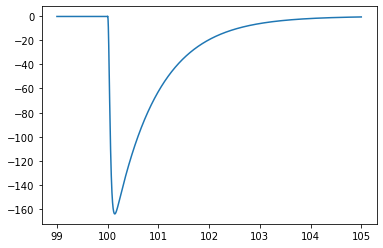

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(d.time(), d['ina.INa'])
plt.show()

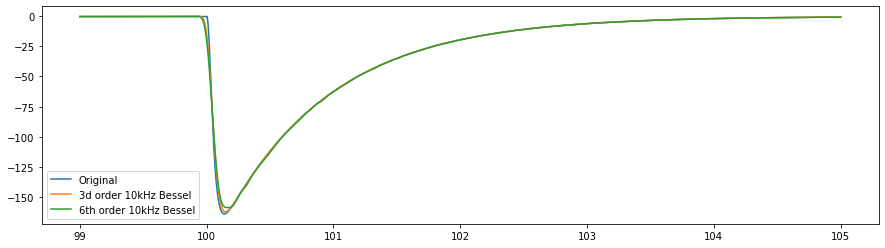

In [7]:
import scipy.signal

t = d.time()
dt = np.mean(t[1:] - t[:-1])   # In ms
f = 1 / dt     # Sampling frequency, in kHz
w = 10         # Cut-off frequency, in kHz

def low_pass(data, w, f, n=3):
    """ Apply a Bessel low-pass filter with cut-off w (in Hz). """
    w = w / (f / 2)
    b, a = scipy.signal.bessel(n, w, btype='lowpass')
    return scipy.signal.filtfilt(b, a, data)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot()
ax.plot(t, d['ina.INa'], label='Original')
ax.plot(t, low_pass(d['ina.INa'], 10, f, 3), label='3d order 10kHz Bessel')
ax.plot(t, low_pass(d['ina.INa'], 10, f, 6), label='6th order 10kHz Bessel')
ax.legend()
plt.show()

For this fast current, the filtering does seem to have a notable effect.
It's also worth noting that, in the published EPC-9 design, the $R_s$ compensation uses a signal that has been passed through this filter.

For now, we will not include the filter in our model.

## Simulations

As before, we can code this up in Myokit and simulate a voltage step:

In [31]:
m = myokit.parse_model('''
[[model]]
desc: Compensated model
amp.Vm = -80
amp.Vp = -80
amp.Vo = -80
amp.Ve = -80
amp.Vr = -80

[amp]
alpha = 0.6
beta = 0.6
time = 0 [ms] in [ms] bind time
I = 50 [pA] in [pA]
E = 1 [mV] in [mV]
Vc = -20 [mV] in [mV]
Cm = 40 [pF] in [pF]
Cm_est = 40 [pF] in [pF]
Cp = 4.5 [pF] in [pF]
Cp_est = 4.5 [pF] in [pF]
Cf = 0.3 [pF] in [pF]
Rs = 0.01 [GOhm] in [GOhm]
Rs_est = 0.01 [GOhm] in [GOhm]
Rf = 0.025 [GOhm] in [GOhm]
tau_amp = 50e-6 [ms] in [ms]
tau_sum = 40e-3 [ms] in [ms]
dot(Vm) = (Vp + E - Vm) / (Rs * Cm) - I / Cm
    in [mV]
dot(Vp) = ((Vo - Vp) / Rf - (Vp + E - Vm) / Rs +
            Cf * dot(Vo) + Cm * dot(Ve) + Cp * dot(Vr)
          ) / (Cp + Cf) : Eq 2a
    in [mV]
dot(Vo) = (Vr - Vp) / tau_amp
    in [mV]
dot(Ve) = (Vc - Ve) / if(tau < 1e-12 [ms], 1e-12 [ms], tau)
    in [mV]
    tau = (1 - beta) * Rs_est * Cm_est
        in [ms]
dot(Vr) = (Vc + alpha * Rs_est * I_obs + beta * Rs_est * Cm_est * dot(Ve) - Vr) / tau_sum
    in [mV]
I_obs = (Vo - Vr) / Rf
    in [pA]
''')
m.check_units(myokit.UNIT_STRICT)

In [32]:
s = myokit.Simulation(m)
dB = s.run(3)
s.reset()
s.set_constant('amp.alpha', 0)
s.set_constant('amp.beta', 0)
s.set_constant('amp.Cm_est', 0)
s.set_constant('amp.Cp_est', 0)
dA = s.run(3)

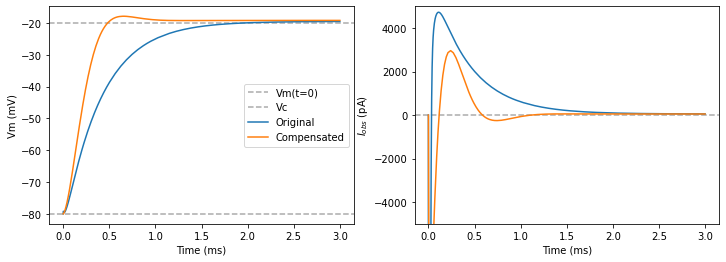

In [33]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Vm (mV)')
kw = dict(color='#aaa', ls='--')
ax.axhline(m.get('amp.Vm').initial_value().eval(), label='Vm(t=0)', **kw)
ax.axhline(m.get('amp.Vc').eval(), label='Vc', **kw)
ax.plot(dA.time(), dA['amp.Vm'], label='Original')
ax.plot(dB.time(), dB['amp.Vm'], label='Compensated')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('$I_{obs}$ (pA)')
kw = dict(color='#aaa', ls='--')
ax.axhline(0, **kw)
ax.plot(dA.time(), dA['amp.I_obs'])
ax.plot(dB.time(), dB['amp.I_obs'])
ax.set_ylim(-5000, 5000)

plt.show()

## Conclusion

In this notebook we have introduced and modelled five types of compensation:

1. Zeroing the voltage
2. Fast capacitative transient cancellation
3. Slow capacitative transient cancellation
4. Series resistance correction
5. Series resistance prediction

In the next notebook we will run simulations to investigate the effects of the model parameters in detail.